<a href="https://colab.research.google.com/github/potohodnica/magistrska/blob/main/GALAH_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load libraries

In [1]:
# System libraries
import os, urllib
import glob
from tqdm.notebook import tqdm

# Astro libraries
import astropy.io.fits as pyfits

# PyTorch Specific libraries
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable

# Data manipulation and visualisation specific libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

# For splitting the data into Train and Test set
from sklearn.model_selection import train_test_split

# This piece of code is required to make use of the GPU instead of CPU for faster processing
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(device)

# If it prints "cuda:0" that means it has access to GPU. If it prints out "cpu", then it's still running on CPU.

import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Settings

In [18]:
# Adjust directory you want to work in
working_directory = '/content/drive/My Drive/'
spectra_directory = '/content/drive/My Drive/mag_sp_mini_dl/'
os.chdir(working_directory)

# Choose if you want to plot the normalised or reduced spectra
normalised = False

# Print messages
printmsg = False

ccd_dict = {
  #1: "B",
 # 2: "G",
  3: "R",
 # 4: "I"
  }

ccd_list_keys = list(ccd_dict.keys())
ccd_len = len(ccd_list_keys)

# Number of binaries and all types of spectra to work with. Input n_all = -1, if you want all available spectra.
n_all = 5000
bin_ratio = 0.3
epochs = 5
batch_size = 500

# Model variables

n_pool = 3
conv_l1_out = 125
kernel_l1 = 5
dropout_l1 = 0.5

kernel_l2 = 3
conv_l2_out = 30
dropout_l2 = 0.5

lin_l3_out = 250
lin_l4_out = 250

softmax_dim = 1

adam_lr = 0.0015

# Preparing GALAH data

### Download sobject_ids

In [4]:
def download_sobject_ids(bin_or_all):
  try:
    link= 'https://raw.githubusercontent.com/potohodnica/magistrska/main/galah_' + bin_or_all + '.tsv'
    urllib.request.urlretrieve(link, spectra_directory + 'galah_' + bin_or_all + '.tsv')
  except:
    if printmsg:
      print('Download error osubject_ids.')

### Sort and merge sobject_ids

In [5]:
def sort_sobject_ids(bin_or_all, n):
  if bin_or_all == 'bin':
    skiprows = 40
  else:
    skiprows = 37
  df = pd.read_csv("galah_" + bin_or_all + ".tsv", on_bad_lines='skip', sep = ";", skiprows=skiprows, usecols = ['GALAH'], dtype='unicode').drop([0, 1])
  df.rename(columns={'GALAH': 'sobject_id'}, inplace=True)
  if not n == -1:
    df = df.sample(n=n, random_state=42)
  df["sobject_id"] = pd.to_numeric(df["sobject_id"])
  return df

def merge_sobject_ids():
  if not os.path.isfile('/content/drive/My Drive/' + 'galah_bin.tsv'):
      download_sobject_ids('bin')
  if not os.path.isfile('/content/drive/My Drive/' + 'galah_all.tsv'):
      download_sobject_ids('all')

  df_bin = sort_sobject_ids('bin', int(n_all * bin_ratio))
  df_all = sort_sobject_ids('all', n_all)
  df_merged = pd.merge(df_all, df_bin, how='outer', indicator=True)

  df_merged.loc[df_merged['_merge']  == 'left_only', 'bin_tf'] = 0
  df_merged.loc[df_merged['_merge']  == 'both', 'bin_tf'] = 1
  df_merged.loc[df_merged['_merge']  == 'right_only', 'bin_tf'] = 1
  df_merged.drop(['_merge'], axis=1, inplace=True)

  df_merged.to_csv("merged_dfs/merged_n" + str(n_all) + "_br" + str(bin_ratio) + "_e" + str(epochs) + ".csv", sep='\t')
  return df_merged

### Download spectra

In [6]:
def download_spectra(sobject_id,ccd):
    """
    Try to download the specfici spectrum from Datacentral
    """
   
    try:
      link = 'https://datacentral.org.au/vo/slink/links?ID=' + str(sobject_id) + '&DR=galah_dr3&IDX=0&FILT=' + ccd_dict[ccd] + '&RESPONSEFORMAT=fits'
      urllib.request.urlretrieve(link, spectra_directory + str(sobject_id) + str(ccd) + '.fits')
      return [spectra_directory + str(sobject_id) + str(ccd) + '.fits']
      print("loaded")
    except:
      if printmsg:
        print('FITS ' + str(sobject_id) + str(ccd) + ' not available')
      return []

### Read spectra

In [7]:
def read_spectra(sobject_id):
    """
    Read in all available CCDs and give back a dictionary
    Download them if not already in working directory
    """
    
    # Check if FITS files already available in working directory
    fits_files = [[], [], [], []]
    for each_ccd in ccd_list_keys:
        fits_files[each_ccd-1] = glob.glob(spectra_directory+str(sobject_id)+str(each_ccd)+'.fits')
    # If not already available, try to download
    #for each_ccd in ccd_list_keys:
     #   if fits_files[each_ccd-1] == []:
      #      fits_files[each_ccd-1] = download_spectra(sobject_id,each_ccd) 
    

    spectrum = dict()

    for each_ccd in ccd_list_keys:
        if fits_files[each_ccd-1]!=[]:
            fits = pyfits.open(fits_files[each_ccd-1][0])

            # Extension 0: Reduced spectrum
            # Extension 1: Relative error spectrum
            # Extension 4: Normalised spectrum, NB: cut for CCD4

            if len(fits) == 5:
              ext1 = True
              ext4 = True
            elif len(fits) == 2:
              ext1 = True
              ext4 = False
              if printmsg:
                print('Normalised spectrum missing in',str(each_ccd),'ccd.')
            else:
              ext1 = False
              ext4 = False
              if printmsg:
                print('Relative error spectrum and normalised spectrum missing in',str(each_ccd),'ccd.')

            # Extract wavelength grid for the reduced spectrum
            start_wavelength = fits[0].header["CRVAL1"]
            dispersion       = fits[0].header["CDELT1"]
            nr_pixels        = fits[0].header["NAXIS1"]
            reference_pixel  = fits[0].header["CRPIX1"]
            if reference_pixel == 0:
                reference_pixel = 1
            spectrum['wave_red_'+str(each_ccd)] = ((np.arange(0,nr_pixels)--reference_pixel+1)*dispersion+start_wavelength)

            if ext4:
              # Extract wavelength grid for the normalised spectrum

              start_wavelength = fits[4].header["CRVAL1"]
              dispersion       = fits[4].header["CDELT1"]
              nr_pixels        = fits[4].header["NAXIS1"]
              reference_pixel  = fits[4].header["CRPIX1"]
              if reference_pixel == 0:
                reference_pixel=1
              spectrum['wave_norm_'+str(each_ccd)] = ((np.arange(0,nr_pixels)--reference_pixel+1)*dispersion+start_wavelength)

            # Extract flux and flux error of reduced spectrum
            # Added byteswap for Pandas use ----> https://stackoverflow.com/questions/30283836/creating-pandas-dataframe-from-numpy-array-leads-to-strange-errors
            spectrum['sob_red_'+str(each_ccd)]  = np.array(fits[0].data).byteswap().newbyteorder()
            if ext1:
              spectrum['uob_red_'+str(each_ccd)]  = np.array(fits[0].data * fits[1].data)

            if ext4 and ext1: 
              # Extract flux and flux error of normalised spectrum
              spectrum['sob_norm_'+str(each_ccd)] = np.array(fits[4].data)
              if each_ccd != 4:
                 spectrum['uob_norm_'+str(each_ccd)] = np.array(fits[4].data * fits[1].data)
              else:
                 # for normalised error of CCD4, only used appropriate parts of error spectrum
                 spectrum['uob_norm_4'] = np.array(fits[4].data * (fits[1].data)[-len(spectrum['sob_norm_4']):])

            fits.close()
        else:
            spectrum['wave_red_'+str(each_ccd)] = []
            spectrum['wave_norm_'+str(each_ccd)] = []
            spectrum['sob_red_'+str(each_ccd)] = []
            spectrum['sob_norm_'+str(each_ccd)] = []
            spectrum['uob_red_'+str(each_ccd)] = []
            spectrum['uob_norm_'+str(each_ccd)] = []
    
    spectrum['wave_red'] = np.concatenate(([spectrum['wave_red_'+str(each_ccd)] for each_ccd in ccd_list_keys]))
    spectrum['sob_red'] = np.concatenate(([spectrum['sob_red_'+str(each_ccd)] for each_ccd in ccd_list_keys]))
    if ext4:
       spectrum['sob_norm'] = np.concatenate(([spectrum['sob_norm_'+str(each_ccd)] for each_ccd in ccd_list_keys]))
       spectrum['wave_norm'] = np.concatenate(([spectrum['wave_norm_'+str(each_ccd)] for each_ccd in ccd_list_keys]))
    if ext1:
       spectrum['uob_red'] = np.concatenate(([spectrum['uob_red_'+str(each_ccd)] for each_ccd in ccd_list_keys]))
    if ext1 and ext4:
       spectrum['uob_norm'] = np.concatenate(([spectrum['uob_norm_'+str(each_ccd)] for each_ccd in ccd_list_keys]))
   
    return spectrum

### Create training set

In [8]:
def create_training_set(df_sobject_ids):

  X = np.empty(shape=(len(df_sobject_ids.index), 4096, ccd_len))
  row = 0
 
  for sobject_id in (pbar :=tqdm(df_sobject_ids["sobject_id"].tolist(), leave = False)):
      pbar.set_description(f"sobject_id {sobject_id}")
      channels = []
      try:
        spectrum = read_spectra(sobject_id)
      except:
        continue

      for channel_nr in ccd_list_keys:
        channel = np.array(spectrum['sob_red_' + str(channel_nr)])
        if len(channel) < 4096:
          channel = np.pad(channel.astype(float), (0, 4096*1 - channel.size), mode='constant', constant_values=np.nan).reshape(4096,)
        elif len(channel) > 4096:
          channel = channel[:4096]
        channels.append(channel)

      X[row] =  np.stack(channels, axis=1)
      row = row + 1
  y = df_sobject_ids.bin_tf.values

  X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.1, random_state = 1)
  
  X_train_t = torch.from_numpy(X_train).transpose(1,2).float() 
  y_train_t = torch.from_numpy(y_train).float().type(torch.LongTensor)

  return X_train_t, X_test, y_train_t, y_test

# Setting pyTorch CNN

### Define model, loss function and optimizer

In [9]:
class ConvNet1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(ccd_len, conv_l1_out, kernel_size=kernel_l1),
            nn.ReLU(),
            nn.Dropout(dropout_l1),
            nn.AdaptiveMaxPool1d(n_pool))
        self.layer2 = nn.Flatten()
        self.layer3 = nn.Sequential(
            nn.Linear(n_pool * conv_l1_out, lin_l3_out),
            nn.Softmax(dim = softmax_dim))

    def forward(self, x):

        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

model = ConvNet1D()
criterion = nn.CrossEntropyLoss() #Loss function
optimizer = optim.Adam(model.parameters(), lr = adam_lr)

torch.save(model.state_dict(), "models/n" + str(n_all) + "_br" + str(bin_ratio) + "_e" + str(epochs) + ".pt")

### Learn

In [10]:
def learn(X_train_t, y_train_t):

  loss_list = []
  outputs_by_epoch = []

  for epoch in tqdm(range(epochs)):
    # Run the forward pass
    outputs_t = model(X_train_t)

    loss = criterion(outputs_t, y_train_t)
    loss_list.append(loss.item())

    # Backprop and perform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    outputs_by_epoch.append(outputs_t.cpu().detach().numpy() ) 
  return outputs_by_epoch, y_train_t.cpu().detach().numpy()

### Learn with batches

In [11]:
def learn_batches():

  loss_list = []
  outputs_by_epoch = []
  y_train = []
   
  df_sobject_ids = merge_sobject_ids()

  n = len(df_sobject_ids.index)                              
  parts = n/batch_size
  df_shuffled = df_sobject_ids.sample(frac=1, random_state = 42)
  df_splits = np.array_split(df_shuffled, parts)

  for epoch in (pbar := tqdm(range(epochs))):
    pbar.set_description(f"Epoch {epoch}")
    batch_nr = 0
    for df in df_splits:
       # p_bar.n = 7

        # Create train X an y for one batch
        start_time = time.time()
        X_train_t_batch, X_test, y_train_t_batch, y_test = create_training_set(df)
        print("--- nalaganje: ---", (time.time() - start_time))

        # Run the forward pass
        start_time = time.time()
        outputs_t_batch = model(X_train_t_batch)

        loss = criterion(outputs_t_batch, y_train_t_batch)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("--- učenje: ---", (time.time() - start_time))
        # Save batch result
        if batch_nr != 0:
          outputs = np.vstack([outputs, outputs_t_batch.cpu().detach().numpy()])
          y_train = np.concatenate([y_train, y_train_t_batch.cpu().detach().numpy()])
        else:
          outputs = outputs_t_batch.cpu().detach().numpy()
          y_train = y_train_t_batch.cpu().detach().numpy()
        batch_nr += 1
       # p_bar.refresh()
    outputs_by_epoch.append(outputs)

  return outputs_by_epoch, y_train

### Evaluate outputs

In [12]:
def eval_outputs(outputs_by_epoch, y_train):

  #### TODO a more efficient eval_outputs function
  #### df = pd.DataFrame(outputs_by_epoch[0], columns = ['0','1'])
  #### print(df.idxmax(axis=1) )
  
  results_of_eval = np.empty(shape=(len(outputs_by_epoch), len(y_train)))
  for epoch in range(len(outputs_by_epoch)):
    for spectrum in range(len(outputs_by_epoch[epoch])):
       results_of_eval[epoch][spectrum] = outputs_by_epoch[epoch][spectrum, : ][y_train[spectrum]]
  #print("%.16f" % results_of_eval[-1])
  plt.scatter(list(range(len(results_of_eval[0]))), results_of_eval[-1], c = y_train, s = 2)
  #return results_of_eval

# Execution

In [13]:
try:
    df_sobject_ids = pd.read_csv("merged_dfs/merged_n" + str(n_all) + "_br" + str(bin_ratio) + "_e" + str(epochs) + ".csv", sep="\t")
except:
    df_sobject_ids = merge_sobject_ids()

In [14]:
#X_train_t, X_test, y_train_t, y_test = create_training_set(df_sobject_ids)
#outputs_by_epoch, y_train = learn(X_train_t, y_train_t)

In [15]:
outputs_by_epoch, y_train = learn_batches()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/650 [00:00<?, ?it/s]

--- nalaganje: --- 360.13055896759033
--- učenje: --- 12.678472995758057


  0%|          | 0/650 [00:00<?, ?it/s]

--- nalaganje: --- 236.93010568618774
--- učenje: --- 13.143434286117554


  0%|          | 0/650 [00:00<?, ?it/s]

--- nalaganje: --- 5.236483335494995
--- učenje: --- 11.925613403320312


  0%|          | 0/650 [00:00<?, ?it/s]

--- nalaganje: --- 5.155052900314331
--- učenje: --- 12.832526683807373


  0%|          | 0/650 [00:00<?, ?it/s]

--- nalaganje: --- 5.3543877601623535
--- učenje: --- 11.57525110244751


  0%|          | 0/650 [00:00<?, ?it/s]

--- nalaganje: --- 4.979043006896973
--- učenje: --- 11.49091625213623


  0%|          | 0/650 [00:00<?, ?it/s]

--- nalaganje: --- 5.267058849334717
--- učenje: --- 11.293036699295044


  0%|          | 0/650 [00:00<?, ?it/s]

--- nalaganje: --- 4.815965890884399
--- učenje: --- 11.457829713821411


  0%|          | 0/650 [00:00<?, ?it/s]

--- nalaganje: --- 4.9140465259552
--- učenje: --- 12.71674633026123


  0%|          | 0/650 [00:00<?, ?it/s]

--- nalaganje: --- 4.881152629852295
--- učenje: --- 11.477566003799438


In [16]:
for epoch in range(len(outputs_by_epoch)):
    np.savetxt("outputs/outputs_n" + str(n_all) + "_br" + str(bin_ratio) + "_e" + str(epoch) + "-" + str(epochs) + ".csv", outputs_by_epoch[epoch], delimiter=",")
np.savetxt("outputs/y_train_n" + str(n_all) + "_br" + str(bin_ratio) + "_e" + str(epochs) + ".csv", y_train.astype(int), fmt='%i', delimiter=",")

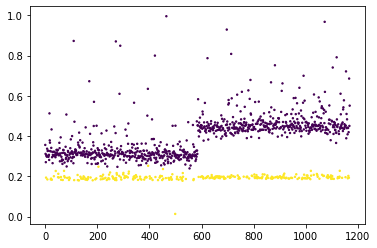

In [17]:
eval_outputs(outputs_by_epoch, y_train)

#eval_outputs(np.genfromtxt("outputs/outputs_n" + str(n_all) + "_br" + str(bin_ratio) + "_e" + str(epoch) + "-" + str(epochs) + ".csv", delimiter=','), 
#             np.genfromtxt("outputs/y_train_n" + str(n_all) + "_br" + str(bin_ratio) + "_e" + str(epochs) + ".csv", delimiter=',').astype(int))